In [2]:
import os
import torch
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import ToTensor, Lambda, Compose,transforms
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import cm
from torch.nn.functional import interpolate

In [3]:
dataset_location = 'C:/Users/sushl/Desktop/deep learning by stanford/synthetic image feature detection/synthetic-image-feature-detection-using-deep-learning/dataset/output'
L = os.listdir(dataset_location)
L.sort()
img_path = []
for i in range(int(len(L))):
    img_path.append(dataset_location +"/"+ L[i])
dataframe = {"path":img_path}
df = pd.DataFrame(dataframe)
df.to_csv("label.csv")


In [6]:
train = pd.read_csv("label.csv")
train

Unnamed: 0                                               path
0               0  C:/Users/sushl/Desktop/deep learning by stanfo...
1               1  C:/Users/sushl/Desktop/deep learning by stanfo...
2               2  C:/Users/sushl/Desktop/deep learning by stanfo...
3               3  C:/Users/sushl/Desktop/deep learning by stanfo...
4               4  C:/Users/sushl/Desktop/deep learning by stanfo...
...           ...                                                ...
89757       89757  C:/Users/sushl/Desktop/deep learning by stanfo...
89758       89758  C:/Users/sushl/Desktop/deep learning by stanfo...
89759       89759  C:/Users/sushl/Desktop/deep learning by stanfo...
89760       89760  C:/Users/sushl/Desktop/deep learning by stanfo...
89761       89761  C:/Users/sushl/Desktop/deep learning by stanfo...

[89762 rows x 2 columns]

In [7]:
dataset_location = 'C:/Users/sushl/Desktop/deep learning by stanford/synthetic image feature detection/synthetic-image-feature-detection-using-deep-learning/dataset/New folder'
L = os.listdir(dataset_location)
L.sort()
img_path = []
for i in range(int(len(L))):
    img_path.append(dataset_location +"/"+ L[i])
dataframe = {"path":img_path}
df = pd.DataFrame(dataframe)
df.to_csv("test.csv")


In [8]:
test = pd.read_csv("test.csv")
test

Unnamed: 0                                               path
0             0  C:/Users/sushl/Desktop/deep learning by stanfo...
1             1  C:/Users/sushl/Desktop/deep learning by stanfo...
2             2  C:/Users/sushl/Desktop/deep learning by stanfo...
3             3  C:/Users/sushl/Desktop/deep learning by stanfo...
4             4  C:/Users/sushl/Desktop/deep learning by stanfo...
..          ...                                                ...
233         233  C:/Users/sushl/Desktop/deep learning by stanfo...
234         234  C:/Users/sushl/Desktop/deep learning by stanfo...
235         235  C:/Users/sushl/Desktop/deep learning by stanfo...
236         236  C:/Users/sushl/Desktop/deep learning by stanfo...
237         237  C:/Users/sushl/Desktop/deep learning by stanfo...

[238 rows x 2 columns]

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file,transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        img = cv.imread(img_path,0)
        image = image/255
        #print(image.dtype)
        gray = np.float32(img)
        dst = cv.cornerHarris(gray,2,3,0.04)
        dst = dst/(dst.max()-dst.min()+0.00001)
        x1 = np.where(dst > 0.05)[0]
        y1 = np.where(dst > 0.05)[1]
        n = len(x1)
        #print(n)
        label12 = np.stack((x1, y1), axis = 1)
        blur = cv.getGaussianKernel(19,4)
        blur = (blur + blur.T)/2
        blur = blur/(blur.max()-blur.min())
        label_img = np.zeros(img.shape)
        for k in range(len(label12)):
            label_img[label12[k,1]-10:label12[k,1]+9,label12[k,0]-10:label12[k,0]+9] = blur*255
        #label = Image.fromarray(np.uint8(cm.gist_earth(label_img)*255))
        label_img = cv.GaussianBlur(label_img,(11,11),0)
        label = torch.from_numpy(label_img.T.reshape(1,200,200))
        label = label/255
        #print(label_img.)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = (image,label)
        return sample

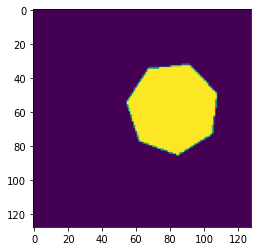

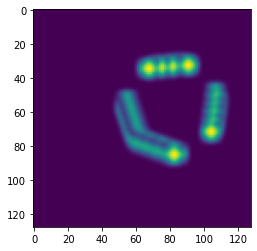

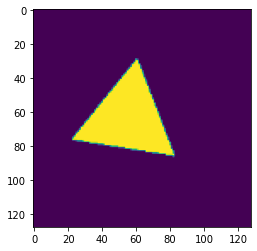

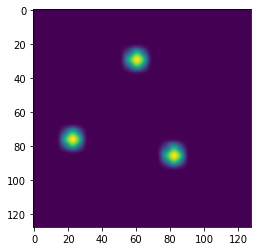

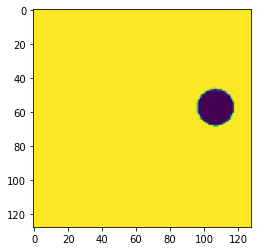

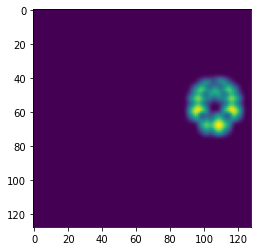

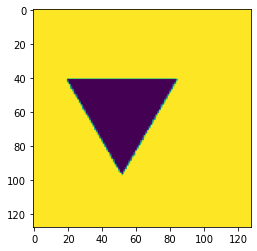

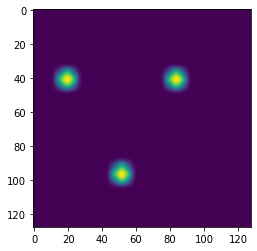

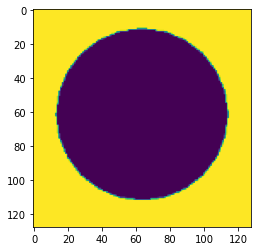

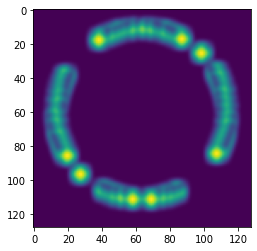

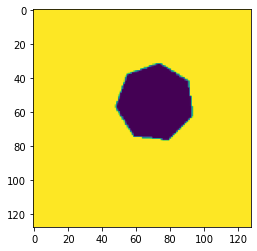

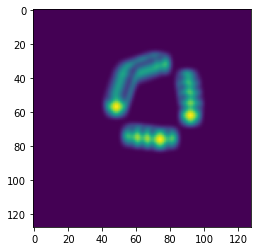

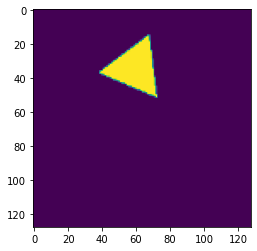

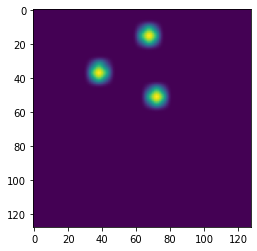

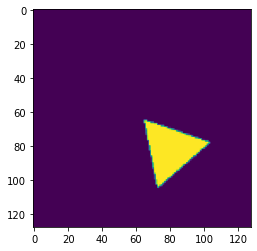

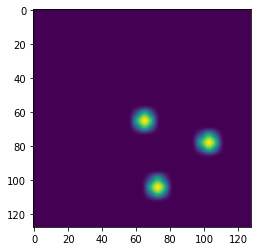

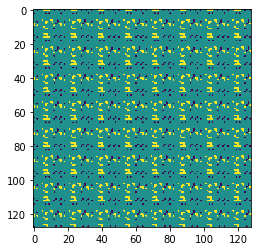

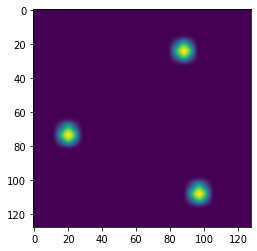

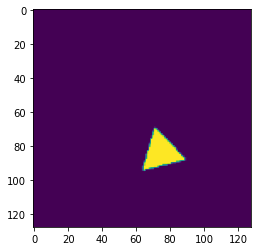

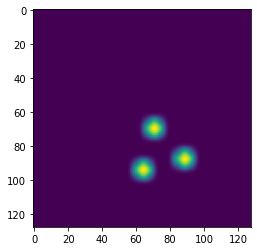

In [12]:
training_data = CustomImageDataset(
    annotations_file= "label.csv",
    transform=transforms.Compose([transforms.Resize((128,128))]),
    target_transform=transforms.Compose([transforms.Resize((128,128))])
)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
train_labels.shape

test_data = CustomImageDataset(
    annotations_file= 'test.csv',
    transform=transforms.Compose([transforms.Resize((128,128))]),
    target_transform=transforms.Compose([transforms.Resize((128,128))])
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
test_features, test_labels = next(iter(test_dataloader))
for i in range(10):
    plt.figure()
    plt.imshow(test_features[i][0].numpy())
    plt.figure()
    plt.imshow(test_labels[i][0].numpy())

In [22]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0)
        self.convT1 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        self.convT2 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0)
        self.convT3 = nn.Conv2d(16, 8, kernel_size=1, stride=1, padding=0)
        self.convT4 = nn.Conv2d(8, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.LeakyReLU()
        self.mp = nn.MaxPool2d(2, 2)
        self.mup = nn.MaxUnpool2d(2,2)
        self.sigmoid = nn.Sigmoid()
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.batchnorm4 = nn.BatchNorm2d(64)
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8,8,kernel_size = 3,stride=1,padding=1),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16,16,kernel_size = 3,stride=1,padding=1),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size = 3,stride=1,padding=1),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64,64,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder1=nn.Sequential(
            nn.ConvTranspose2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,64,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder2=nn.Sequential(
            nn.ConvTranspose2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,32,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder3=nn.Sequential(
            nn.ConvTranspose2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,16,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder4=nn.Sequential(
            nn.ConvTranspose2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8,8,kernel_size = 3,stride=1,padding=1),
        )
    def forward(self, features):
        x = self.encode(features.float())
        x = self.decode(x)
        return x
    
    def encode(self, features):
        x = self.conv1(features.float()) #3 to 8
        residual = x
        x = self.encoder1(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.mp(x)
        x = self.batchnorm1(x)

        x = self.conv2(x) #8 to 16
        residual = x
        x = self.encoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x #16 to 16
        x = self.encoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x #16 to 16
        x = self.encoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.mp(x)
        x = self.batchnorm2(x)
        
        x = self.conv3(x) #16 to 32
        residual = x
        x = self.encoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.encoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.encoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.mp(x)
        x = self.batchnorm3(x)
        
        x = self.conv4(x) #32 to 64
        residual = x
        x = self.encoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        residual = x #64 to 64
        x = self.encoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        residual = x #64 to 64
        x = self.encoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        return x

    def decode(self, features):
        #x = interpolate(features.float(), scale_factor=2)
        residual = features.float() #64 to 64
        x = self.decoder1(features.float())
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        residual = x #64 to 64
        x = self.decoder1(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
         
        x = self.convT1(x) #64 to 32
        x = interpolate(x, scale_factor=2)
        residual = x
        x = self.decoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.decoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.decoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        x = self.convT2(x) #32 to 16
        x = interpolate(x, scale_factor=2)
        residual = x 
        x = self.decoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x #16 to 16
        x = self.decoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x  #16 to 16
        x = self.decoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        x = self.convT3(x) #16 to 8
        x = interpolate(x, scale_factor=2)
        residual = x 
        x = self.decoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        residual = x #8 to 8
        x = self.decoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        residual = x #8 to 8
        x = self.decoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        x = self.convT4(x) #8 to 1
        x = self.sigmoid(x)
        return x
    
model = CNN().to(device)

In [15]:
"""
dummy = torch.ones(64,3,128,128).to(device)
a = model(dummy)
a.shape
"""

'\ndummy = torch.ones(64,3,128,128).to(device)\na = model(dummy)\na.shape\n'

In [16]:
lr = 0.001
m = 0.9
opt = optim.SGD(model.parameters(), lr=lr, momentum=m)
#loss_fn = nn.MSELoss()
loss_fn = nn.BCELoss()
def loss_function(output, target):
    #print(output.max())
    #print(output.min())
    
    #exp_output = exp_output/torch.sum(exp_output)
    
    #print(exp_output.max())
    #print(exp_output.min())
    #plt.figure()
    #plt.imshow(exp_output[0].cpu().detach().numpy().reshape(96,96,1))
    #plt.colorbar()
    #plt.show()
    loss = (torch.sum(torch.sum((output*output - target*target)**2)))**(1/2) #+ (torch.mean(torch.sum((output*(1-target) - (1-target)*(1-target))**2)))**(1/2)
    return loss


wandb: Currently logged in as: sushlokshah (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


loss: 287.468079  [    0/90000]


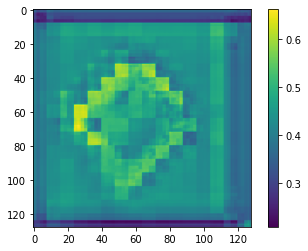

loss: 170.682699  [  128/90000]
loss: 127.375396  [  256/90000]
loss: 112.560434  [  384/90000]
loss: 103.498927  [  512/90000]
loss: 100.019780  [  640/90000]
loss: 95.663380  [  768/90000]
loss: 93.466443  [  896/90000]
loss: 95.615856  [ 1024/90000]


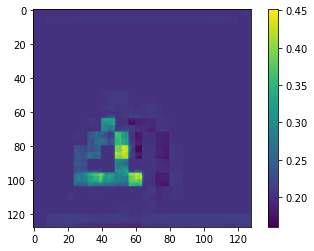

loss: 98.005386  [ 1152/90000]
loss: 92.736213  [ 1280/90000]
loss: 92.163028  [ 1408/90000]
loss: 94.177101  [ 1536/90000]
loss: 92.365249  [ 1664/90000]
loss: 97.953007  [ 1792/90000]
loss: 90.755072  [ 1920/90000]
loss: 93.050441  [ 2048/90000]


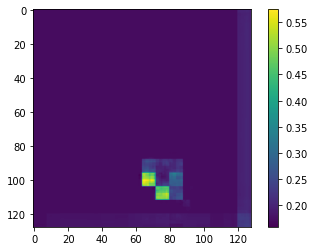

loss: 93.282000  [ 2176/90000]
loss: 90.944449  [ 2304/90000]
loss: 88.036921  [ 2432/90000]
loss: 88.946821  [ 2560/90000]
loss: 87.621458  [ 2688/90000]
loss: 85.643767  [ 2816/90000]
loss: 92.151047  [ 2944/90000]
loss: 93.368632  [ 3072/90000]


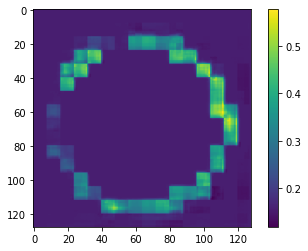

loss: 89.144881  [ 3200/90000]
loss: 90.407202  [ 3328/90000]
loss: 88.253310  [ 3456/90000]
loss: 90.673529  [ 3584/90000]
loss: 85.803757  [ 3712/90000]
loss: 93.071748  [ 3840/90000]
loss: 88.047286  [ 3968/90000]
loss: 91.092938  [ 4096/90000]


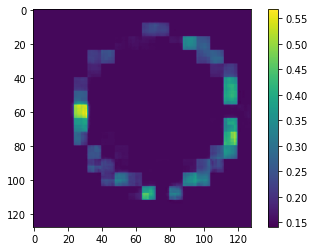

loss: 88.884916  [ 4224/90000]
loss: 89.209245  [ 4352/90000]
loss: 87.247669  [ 4480/90000]
loss: 87.519959  [ 4608/90000]
loss: 85.020105  [ 4736/90000]
loss: 85.311327  [ 4864/90000]
loss: 85.715952  [ 4992/90000]
loss: 89.563481  [ 5120/90000]


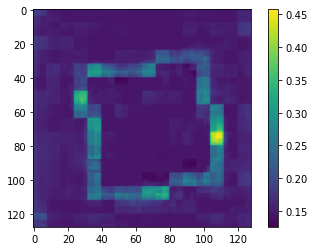

loss: 87.273154  [ 5248/90000]
loss: 84.170869  [ 5376/90000]
loss: 85.523124  [ 5504/90000]
loss: 85.167791  [ 5632/90000]
loss: 87.112897  [ 5760/90000]
loss: 85.736789  [ 5888/90000]
loss: 88.054690  [ 6016/90000]
loss: 85.985890  [ 6144/90000]


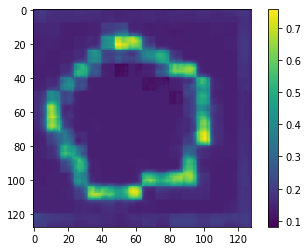

loss: 86.844957  [ 6272/90000]
loss: 81.311590  [ 6400/90000]
loss: 85.171079  [ 6528/90000]
loss: 81.836672  [ 6656/90000]
loss: 82.739118  [ 6784/90000]
loss: 81.413413  [ 6912/90000]
loss: 86.816117  [ 7040/90000]
loss: 83.715588  [ 7168/90000]


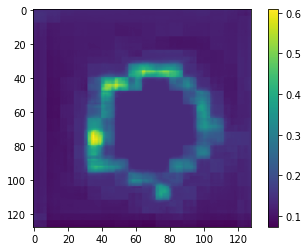

loss: 81.990090  [ 7296/90000]
loss: 84.205897  [ 7424/90000]
loss: 86.149267  [ 7552/90000]
loss: 85.076871  [ 7680/90000]
loss: 81.583984  [ 7808/90000]
loss: 82.868587  [ 7936/90000]
loss: 79.028174  [ 8064/90000]
loss: 82.917628  [ 8192/90000]


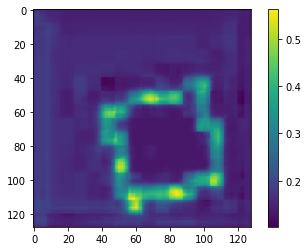

loss: 83.447134  [ 8320/90000]
loss: 77.317125  [ 8448/90000]
loss: 86.413400  [ 8576/90000]
loss: 80.361038  [ 8704/90000]
loss: 83.300109  [ 8832/90000]
loss: 81.154116  [ 8960/90000]
loss: 82.417900  [ 9088/90000]
loss: 79.759701  [ 9216/90000]


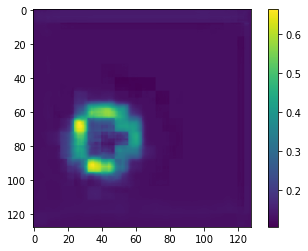

loss: 84.006130  [ 9344/90000]
loss: 81.893181  [ 9472/90000]
loss: 81.659914  [ 9600/90000]
loss: 80.323967  [ 9728/90000]
loss: 80.392481  [ 9856/90000]
loss: 76.582706  [ 9984/90000]
loss: 77.583376  [10112/90000]
loss: 74.737169  [10240/90000]


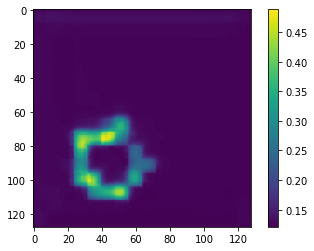

loss: 77.697950  [10368/90000]
loss: 76.846932  [10496/90000]
loss: 75.397331  [10624/90000]
loss: 78.478669  [10752/90000]
loss: 77.145330  [10880/90000]
loss: 75.633678  [11008/90000]
loss: 76.461133  [11136/90000]
loss: 75.051073  [11264/90000]


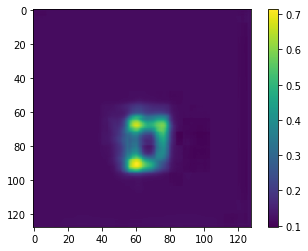

loss: 78.919289  [11392/90000]
loss: 75.858751  [11520/90000]
loss: 76.005649  [11648/90000]
loss: 75.506319  [11776/90000]
loss: 73.318167  [11904/90000]
loss: 74.203832  [12032/90000]
loss: 74.456244  [12160/90000]
loss: 78.997819  [12288/90000]


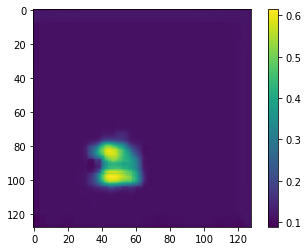

loss: 76.204971  [12416/90000]
loss: 74.861887  [12544/90000]
loss: 74.455917  [12672/90000]
loss: 80.325966  [12800/90000]
loss: 71.260005  [12928/90000]
loss: 73.430372  [13056/90000]
loss: 71.895414  [13184/90000]
loss: 76.131882  [13312/90000]


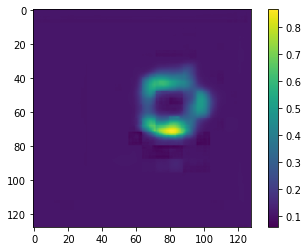

loss: 75.168963  [13440/90000]
loss: 73.592623  [13568/90000]
loss: 75.567531  [13696/90000]
loss: 69.474650  [13824/90000]
loss: 73.602563  [13952/90000]
loss: 71.080531  [14080/90000]
loss: 77.834856  [14208/90000]
loss: 71.389898  [14336/90000]


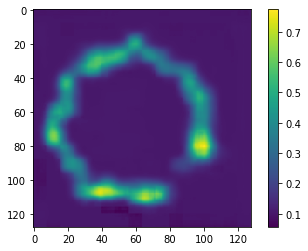

loss: 74.183220  [14464/90000]
loss: 75.706708  [14592/90000]
loss: 67.704960  [14720/90000]
loss: 71.331877  [14848/90000]
loss: 72.179641  [14976/90000]
loss: 73.113850  [15104/90000]
loss: 70.867148  [15232/90000]
loss: 74.081057  [15360/90000]


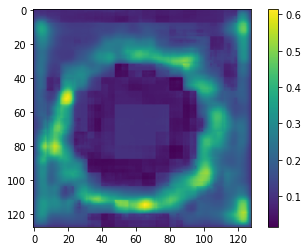

loss: 69.222137  [15488/90000]
loss: 69.621484  [15616/90000]
loss: 68.122749  [15744/90000]
loss: 72.518531  [15872/90000]
loss: 68.391109  [16000/90000]
loss: 71.228639  [16128/90000]
loss: 66.778989  [16256/90000]
loss: 67.640431  [16384/90000]


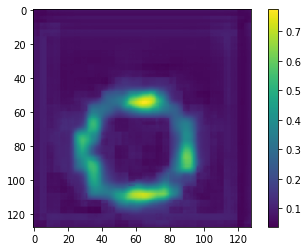

loss: 74.805147  [16512/90000]
loss: 74.886557  [16640/90000]
loss: 75.818867  [16768/90000]
loss: 70.094818  [16896/90000]
loss: 68.710560  [17024/90000]
loss: 64.059415  [17152/90000]
loss: 66.037758  [17280/90000]
loss: 68.183066  [17408/90000]


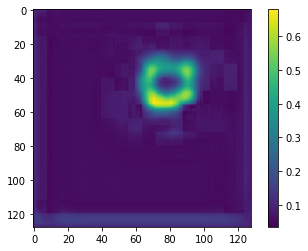

loss: 65.860141  [17536/90000]
loss: 66.351137  [17664/90000]
loss: 68.302551  [17792/90000]
loss: 68.646634  [17920/90000]
loss: 71.885438  [18048/90000]
loss: 61.606977  [18176/90000]
loss: 67.793729  [18304/90000]
loss: 69.923788  [18432/90000]


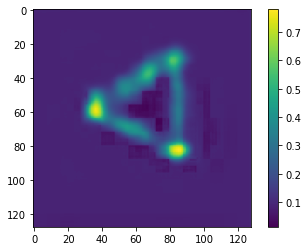

loss: 70.852456  [18560/90000]
loss: 72.377966  [18688/90000]
loss: 68.560176  [18816/90000]
loss: 71.262157  [18944/90000]
loss: 69.426071  [19072/90000]
loss: 67.743498  [19200/90000]
loss: 62.928689  [19328/90000]
loss: 68.466068  [19456/90000]


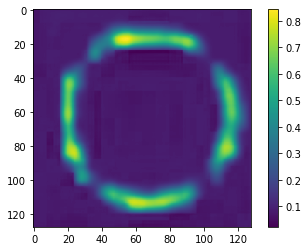

loss: 69.270510  [19584/90000]
loss: 61.201581  [19712/90000]
loss: 64.610604  [19840/90000]
loss: 69.985734  [19968/90000]
loss: 70.874706  [20096/90000]
loss: 71.034811  [20224/90000]
loss: 69.173899  [20352/90000]
loss: 70.171800  [20480/90000]


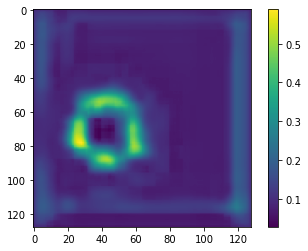

loss: 67.657284  [20608/90000]
loss: 68.488382  [20736/90000]
loss: 65.633560  [20864/90000]
loss: 66.333191  [20992/90000]
loss: 72.325392  [21120/90000]
loss: 63.080237  [21248/90000]
loss: 65.439263  [21376/90000]
loss: 62.841048  [21504/90000]


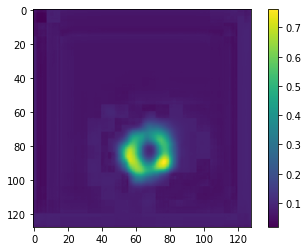

loss: 64.996365  [21632/90000]
loss: 63.174684  [21760/90000]
loss: 63.302823  [21888/90000]
loss: 60.485216  [22016/90000]
loss: 66.219052  [22144/90000]
loss: 64.835942  [22272/90000]
loss: 62.863684  [22400/90000]
loss: 57.795850  [22528/90000]


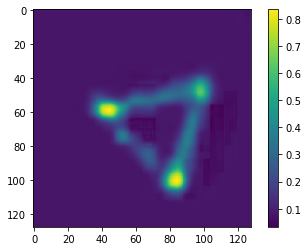

loss: 60.683688  [22656/90000]
loss: 65.305188  [22784/90000]
loss: 67.010060  [22912/90000]
loss: 61.606359  [23040/90000]
loss: 61.545337  [23168/90000]
loss: 70.370912  [23296/90000]
loss: 67.965158  [23424/90000]
loss: 63.782836  [23552/90000]


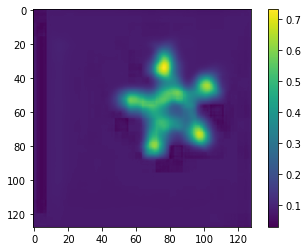

loss: 68.139245  [23680/90000]
loss: 63.173536  [23808/90000]
loss: 62.467157  [23936/90000]
loss: 63.865286  [24064/90000]
loss: 65.088200  [24192/90000]
loss: 59.397358  [24320/90000]
loss: 58.394318  [24448/90000]
loss: 62.875059  [24576/90000]


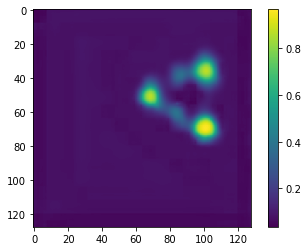

loss: 56.889485  [24704/90000]
loss: 59.216483  [24832/90000]
loss: 63.802104  [24960/90000]
loss: 61.210997  [25088/90000]
loss: 60.922395  [25216/90000]
loss: 61.523066  [25344/90000]
loss: 60.556906  [25472/90000]
loss: 59.837839  [25600/90000]


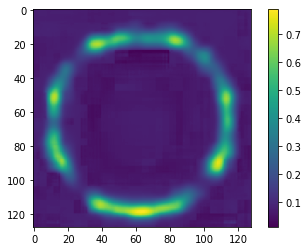

loss: 60.816525  [25728/90000]
loss: 60.805648  [25856/90000]
loss: 71.010335  [25984/90000]
loss: 64.752318  [26112/90000]
loss: 67.156978  [26240/90000]
loss: 62.468881  [26368/90000]
loss: 61.031857  [26496/90000]
loss: 65.068971  [26624/90000]


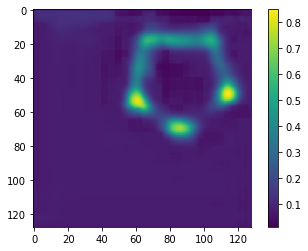

loss: 61.448572  [26752/90000]
loss: 63.144131  [26880/90000]
loss: 57.110250  [27008/90000]
loss: 62.805884  [27136/90000]
loss: 62.639223  [27264/90000]
loss: 62.677739  [27392/90000]
loss: 72.968698  [27520/90000]
loss: 57.359892  [27648/90000]


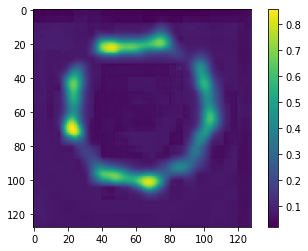

loss: 58.605615  [27776/90000]
loss: 63.361932  [27904/90000]
loss: 60.060454  [28032/90000]
loss: 61.190391  [28160/90000]
loss: 62.455879  [28288/90000]
loss: 63.353420  [28416/90000]
loss: 58.939169  [28544/90000]
loss: 61.885495  [28672/90000]


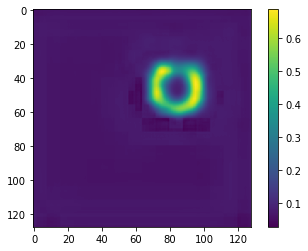

loss: 68.039703  [28800/90000]
loss: 57.983289  [28928/90000]
loss: 63.603724  [29056/90000]
loss: 61.427687  [29184/90000]
loss: 59.073896  [29312/90000]
loss: 65.538501  [29440/90000]
loss: 60.436702  [29568/90000]
loss: 59.742350  [29696/90000]


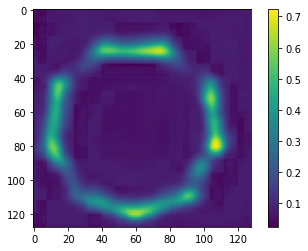

loss: 58.204884  [29824/90000]
loss: 63.700102  [29952/90000]
loss: 55.886863  [30080/90000]
loss: 55.606796  [30208/90000]
loss: 61.617724  [30336/90000]
loss: 54.760469  [30464/90000]
loss: 58.329807  [30592/90000]
loss: 57.241787  [30720/90000]


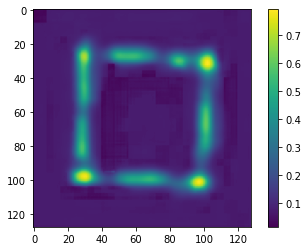

loss: 58.069668  [30848/90000]
loss: 62.169972  [30976/90000]
loss: 53.939014  [31104/90000]
loss: 56.557437  [31232/90000]
loss: 56.276336  [31360/90000]
loss: 53.645621  [31488/90000]
loss: 55.122150  [31616/90000]
loss: 54.478889  [31744/90000]


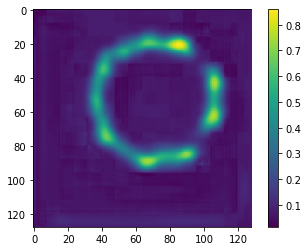

loss: 61.452065  [31872/90000]
loss: 62.960687  [32000/90000]
loss: 59.289437  [32128/90000]
loss: 53.164995  [32256/90000]
loss: 53.984643  [32384/90000]
loss: 55.613914  [32512/90000]
loss: 56.583315  [32640/90000]
loss: 60.055280  [32768/90000]


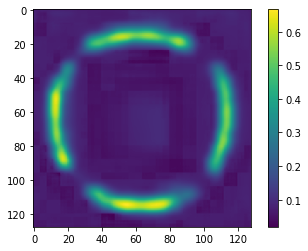

loss: 55.683052  [32896/90000]
loss: 53.534166  [33024/90000]
loss: 54.736194  [33152/90000]
loss: 57.587647  [33280/90000]
loss: 54.745622  [33408/90000]
loss: 58.774697  [33536/90000]
loss: 57.821408  [33664/90000]
loss: 53.896876  [33792/90000]


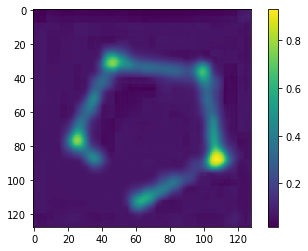

loss: 60.312362  [33920/90000]
loss: 55.246764  [34048/90000]
loss: 51.912525  [34176/90000]
loss: 56.493638  [34304/90000]
loss: 55.509224  [34432/90000]
loss: 61.406438  [34560/90000]
loss: 58.834729  [34688/90000]
loss: 52.574902  [34816/90000]


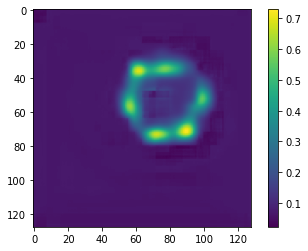

loss: 61.108586  [34944/90000]
loss: 60.205386  [35072/90000]
loss: 55.274627  [35200/90000]
loss: 50.536954  [35328/90000]
loss: 53.214150  [35456/90000]
loss: 51.390568  [35584/90000]
loss: 56.623115  [35712/90000]
loss: 55.734999  [35840/90000]


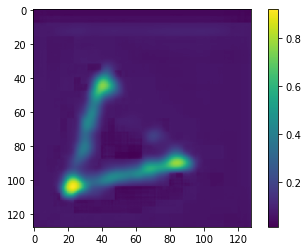

loss: 54.954265  [35968/90000]
loss: 53.977881  [36096/90000]
loss: 58.272176  [36224/90000]
loss: 55.742305  [36352/90000]
loss: 61.526093  [36480/90000]
loss: 54.988038  [36608/90000]
loss: 48.713638  [36736/90000]
loss: 52.506020  [36864/90000]


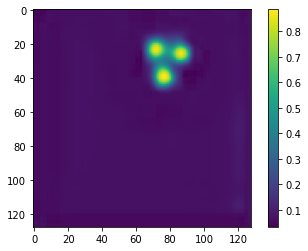

loss: 54.632626  [36992/90000]
loss: 53.489420  [37120/90000]
loss: 49.808502  [37248/90000]
loss: 56.972755  [37376/90000]
loss: 53.743190  [37504/90000]
loss: 53.893203  [37632/90000]
loss: 51.873983  [37760/90000]
loss: 64.035894  [37888/90000]


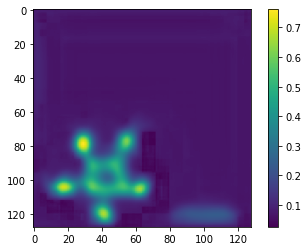

loss: 50.717608  [38016/90000]
loss: 49.932908  [38144/90000]
loss: 50.666664  [38272/90000]
loss: 58.577141  [38400/90000]
loss: 57.836760  [38528/90000]
loss: 53.774271  [38656/90000]
loss: 60.369172  [38784/90000]
loss: 52.079125  [38912/90000]


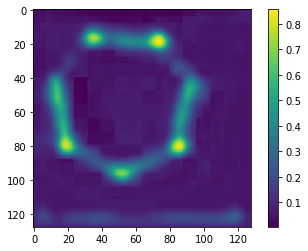

loss: 59.222597  [39040/90000]
loss: 59.977971  [39168/90000]
loss: 53.323516  [39296/90000]
loss: 55.608272  [39424/90000]
loss: 56.044408  [39552/90000]
loss: 58.870723  [39680/90000]
loss: 51.085015  [39808/90000]
loss: 53.276709  [39936/90000]


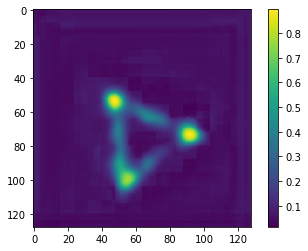

loss: 56.778537  [40064/90000]
loss: 52.403685  [40192/90000]
loss: 54.016490  [40320/90000]
loss: 51.705781  [40448/90000]
loss: 52.408071  [40576/90000]
loss: 53.357903  [40704/90000]
loss: 53.241032  [40832/90000]
loss: 55.432865  [40960/90000]


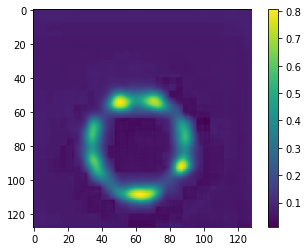

loss: 51.947369  [41088/90000]
loss: 52.688041  [41216/90000]
loss: 55.804335  [41344/90000]
loss: 51.485957  [41472/90000]
loss: 53.024685  [41600/90000]
loss: 51.751210  [41728/90000]
loss: 50.655459  [41856/90000]
loss: 51.745079  [41984/90000]


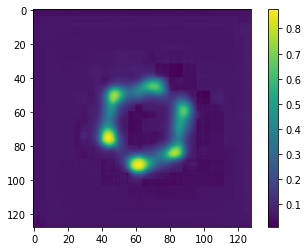

loss: 55.442485  [42112/90000]
loss: 53.071475  [42240/90000]
loss: 50.112519  [42368/90000]
loss: 53.624418  [42496/90000]
loss: 51.844549  [42624/90000]
loss: 49.427033  [42752/90000]
loss: 51.846037  [42880/90000]
loss: 52.263064  [43008/90000]


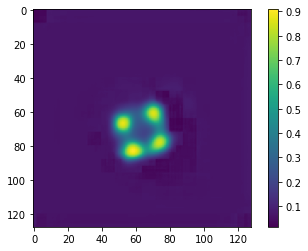

loss: 51.718080  [43136/90000]
loss: 53.494242  [43264/90000]
loss: 51.806490  [43392/90000]
loss: 52.266120  [43520/90000]
loss: 56.042649  [43648/90000]
loss: 50.960835  [43776/90000]
loss: 48.410776  [43904/90000]
loss: 55.064419  [44032/90000]


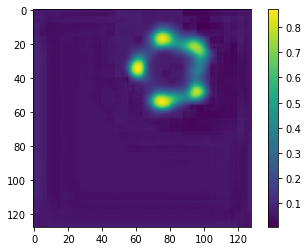

loss: 53.041528  [44160/90000]
loss: 55.377046  [44288/90000]
loss: 51.148585  [44416/90000]
loss: 50.654903  [44544/90000]
loss: 55.172356  [44672/90000]
loss: 50.361256  [44800/90000]
loss: 48.329781  [44928/90000]
loss: 53.710941  [45056/90000]


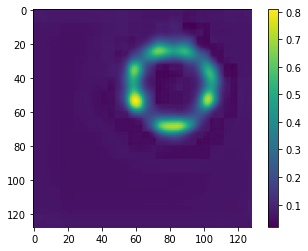

loss: 54.355257  [45184/90000]
loss: 51.232136  [45312/90000]
loss: 51.879519  [45440/90000]
loss: 56.815193  [45568/90000]
loss: 48.903197  [45696/90000]
loss: 50.467185  [45824/90000]
loss: 51.504857  [45952/90000]
loss: 48.764730  [46080/90000]


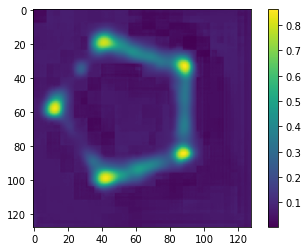

loss: 51.721860  [46208/90000]
loss: 52.604786  [46336/90000]
loss: 46.874873  [46464/90000]
loss: 47.819785  [46592/90000]
loss: 50.351502  [46720/90000]
loss: 51.886646  [46848/90000]
loss: 48.320343  [46976/90000]
loss: 51.091895  [47104/90000]


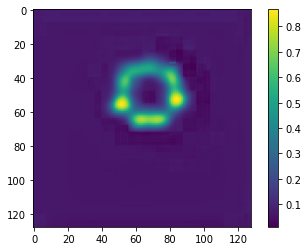

loss: 51.355907  [47232/90000]
loss: 56.798534  [47360/90000]
loss: 56.097000  [47488/90000]
loss: 49.654969  [47616/90000]
loss: 50.137787  [47744/90000]
loss: 49.673137  [47872/90000]
loss: 46.615721  [48000/90000]
loss: 47.523280  [48128/90000]


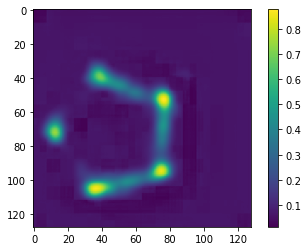

loss: 46.768501  [48256/90000]
loss: 49.272581  [48384/90000]
loss: 49.982832  [48512/90000]
loss: 48.627599  [48640/90000]
loss: 51.513724  [48768/90000]
loss: 54.115700  [48896/90000]
loss: 54.467141  [49024/90000]
loss: 56.267239  [49152/90000]


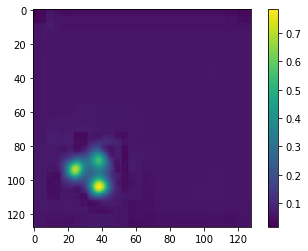

loss: 49.079191  [49280/90000]
loss: 46.362140  [49408/90000]
loss: 50.393983  [49536/90000]
loss: 52.537700  [49664/90000]
loss: 52.479135  [49792/90000]
loss: 51.679027  [49920/90000]
loss: 49.968729  [50048/90000]
loss: 48.456876  [50176/90000]


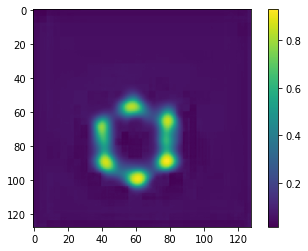

loss: 45.759727  [50304/90000]
loss: 49.774187  [50432/90000]
loss: 47.767024  [50560/90000]
loss: 49.826931  [50688/90000]
loss: 56.704186  [50816/90000]
loss: 51.105123  [50944/90000]
loss: 48.393908  [51072/90000]
loss: 47.225059  [51200/90000]


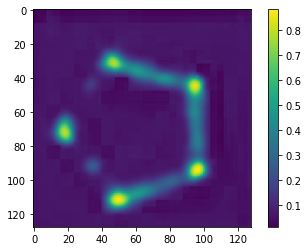

loss: 44.876897  [51328/90000]
loss: 48.405401  [51456/90000]
loss: 50.630438  [51584/90000]
loss: 48.341462  [51712/90000]
loss: 52.446634  [51840/90000]
loss: 52.943437  [51968/90000]
loss: 48.540761  [52096/90000]
loss: 47.428343  [52224/90000]


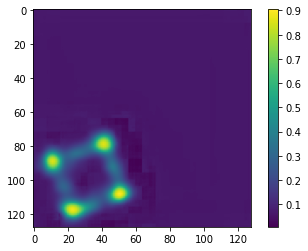

loss: 52.149722  [52352/90000]
loss: 45.013907  [52480/90000]
loss: 48.392913  [52608/90000]
loss: 55.521004  [52736/90000]
loss: 49.802561  [52864/90000]
loss: 49.462723  [52992/90000]
loss: 50.381829  [53120/90000]
loss: 50.249662  [53248/90000]


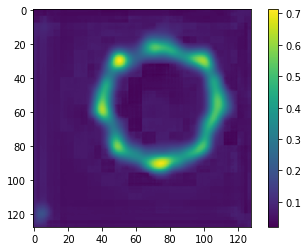

loss: 55.117614  [53376/90000]
loss: 50.388001  [53504/90000]
loss: 48.093670  [53632/90000]
loss: 47.974636  [53760/90000]
loss: 50.891994  [53888/90000]
loss: 50.438111  [54016/90000]
loss: 50.085973  [54144/90000]
loss: 54.584082  [54272/90000]


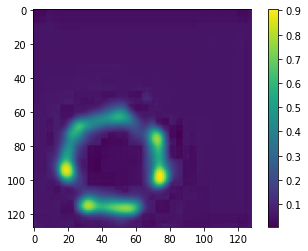

loss: 44.390206  [54400/90000]
loss: 50.514452  [54528/90000]
loss: 50.199260  [54656/90000]
loss: 54.585106  [54784/90000]
loss: 49.401098  [54912/90000]
loss: 50.410288  [55040/90000]
loss: 49.566696  [55168/90000]
loss: 49.205013  [55296/90000]


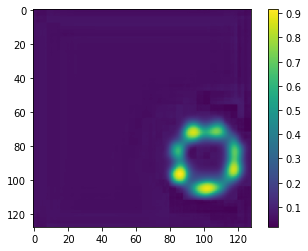

loss: 47.849707  [55424/90000]
loss: 49.861107  [55552/90000]
loss: 46.274201  [55680/90000]
loss: 49.288010  [55808/90000]
loss: 48.991786  [55936/90000]
loss: 50.474225  [56064/90000]
loss: 47.748859  [56192/90000]
loss: 48.945858  [56320/90000]


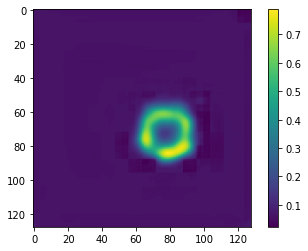

loss: 48.039251  [56448/90000]
loss: 50.993983  [56576/90000]
loss: 47.174263  [56704/90000]
loss: 48.355114  [56832/90000]
loss: 48.085350  [56960/90000]
loss: 48.613144  [57088/90000]
loss: 48.762064  [57216/90000]
loss: 49.882073  [57344/90000]


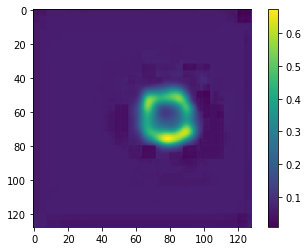

loss: 52.314011  [57472/90000]
loss: 54.334692  [57600/90000]
loss: 49.659861  [57728/90000]
loss: 51.996150  [57856/90000]
loss: 43.349979  [57984/90000]
loss: 49.539862  [58112/90000]
loss: 48.728237  [58240/90000]
loss: 46.741095  [58368/90000]


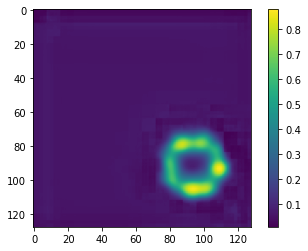

loss: 46.717365  [58496/90000]
loss: 46.132959  [58624/90000]
loss: 43.856027  [58752/90000]
loss: 53.774777  [58880/90000]
loss: 46.356074  [59008/90000]
loss: 47.657483  [59136/90000]
loss: 49.189233  [59264/90000]
loss: 49.281955  [59392/90000]


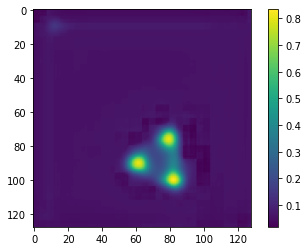

loss: 48.917910  [59520/90000]
loss: 46.976954  [59648/90000]
loss: 49.634563  [59776/90000]
loss: 47.683624  [59904/90000]
loss: 47.961500  [60032/90000]
loss: 46.535665  [60160/90000]
loss: 46.932149  [60288/90000]
loss: 50.173213  [60416/90000]


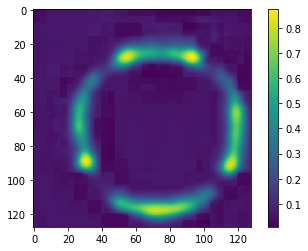

loss: 46.119208  [60544/90000]
loss: 48.921922  [60672/90000]
loss: 49.861954  [60800/90000]
loss: 47.528988  [60928/90000]
loss: 46.182371  [61056/90000]
loss: 47.115969  [61184/90000]
loss: 52.150550  [61312/90000]
loss: 46.727045  [61440/90000]


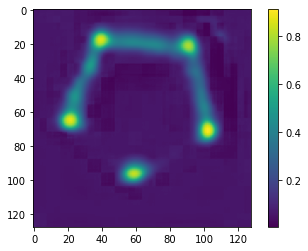

loss: 49.288931  [61568/90000]
loss: 47.163731  [61696/90000]
loss: 49.118347  [61824/90000]
loss: 47.979143  [61952/90000]
loss: 45.220686  [62080/90000]
loss: 47.814330  [62208/90000]
loss: 49.867934  [62336/90000]
loss: 45.754466  [62464/90000]


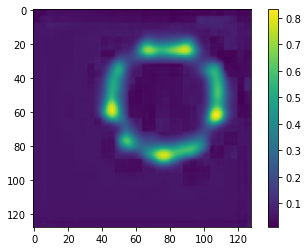

loss: 47.319494  [62592/90000]
loss: 46.747519  [62720/90000]
loss: 47.192257  [62848/90000]
loss: 47.475629  [62976/90000]
loss: 43.643957  [63104/90000]
loss: 48.800805  [63232/90000]
loss: 44.085326  [63360/90000]
loss: 48.470622  [63488/90000]


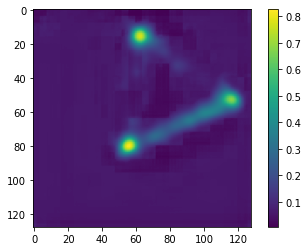

loss: 44.843579  [63616/90000]
loss: 52.145580  [63744/90000]
loss: 47.695830  [63872/90000]
loss: 44.368876  [64000/90000]
loss: 50.140949  [64128/90000]
loss: 47.295136  [64256/90000]
loss: 47.223468  [64384/90000]
loss: 42.769984  [64512/90000]


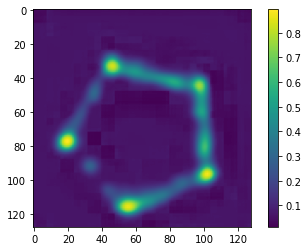

loss: 47.065627  [64640/90000]
loss: 43.906350  [64768/90000]
loss: 46.880563  [64896/90000]
loss: 42.949815  [65024/90000]
loss: 49.136696  [65152/90000]
loss: 47.880934  [65280/90000]
loss: 52.561146  [65408/90000]
loss: 52.429043  [65536/90000]


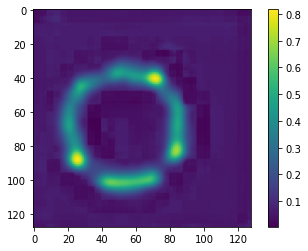

loss: 54.350195  [65664/90000]
loss: 48.466202  [65792/90000]
loss: 47.785473  [65920/90000]
loss: 46.619269  [66048/90000]
loss: 47.751809  [66176/90000]
loss: 53.815205  [66304/90000]
loss: 48.227029  [66432/90000]
loss: 48.608832  [66560/90000]


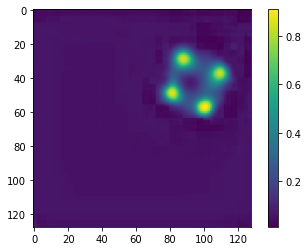

loss: 52.155844  [66688/90000]
loss: 46.385443  [66816/90000]
loss: 43.805123  [66944/90000]
loss: 42.591605  [67072/90000]
loss: 45.137513  [67200/90000]
loss: 45.569562  [67328/90000]
loss: 48.618539  [67456/90000]
loss: 45.295564  [67584/90000]


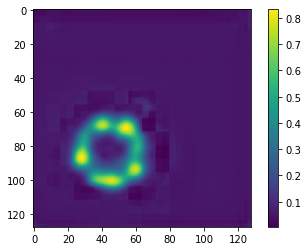

loss: 45.615503  [67712/90000]
loss: 51.275492  [67840/90000]
loss: 49.548044  [67968/90000]
loss: 45.235134  [68096/90000]
loss: 46.240082  [68224/90000]
loss: 52.195089  [68352/90000]
loss: 44.091781  [68480/90000]
loss: 50.277441  [68608/90000]


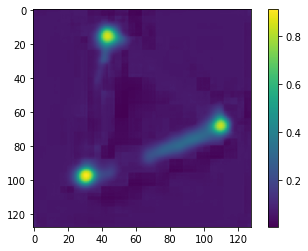

loss: 48.777135  [68736/90000]
loss: 49.682211  [68864/90000]
loss: 49.466131  [68992/90000]
loss: 45.659085  [69120/90000]
loss: 47.754264  [69248/90000]
loss: 48.930739  [69376/90000]
loss: 45.532349  [69504/90000]
loss: 48.885257  [69632/90000]


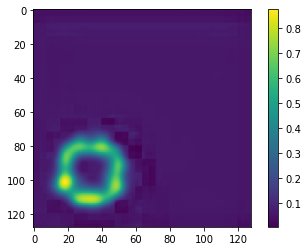

loss: 46.604703  [69760/90000]
loss: 47.428026  [69888/90000]
loss: 44.014186  [70016/90000]
loss: 44.522223  [70144/90000]
loss: 47.625724  [70272/90000]
loss: 44.310439  [70400/90000]
loss: 48.941517  [70528/90000]
loss: 51.005584  [70656/90000]


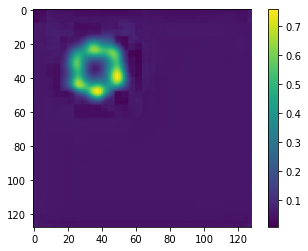

loss: 51.076275  [70784/90000]
loss: 44.111986  [70912/90000]
loss: 43.152484  [71040/90000]
loss: 46.288149  [71168/90000]
loss: 43.794369  [71296/90000]
loss: 45.821426  [71424/90000]
loss: 41.068914  [71552/90000]
loss: 47.495542  [71680/90000]


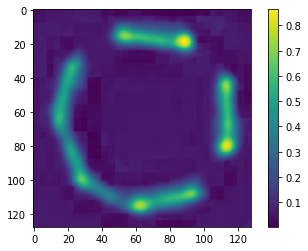

loss: 43.180849  [71808/90000]
loss: 40.556218  [71936/90000]
loss: 40.284196  [72064/90000]
loss: 49.711349  [72192/90000]
loss: 44.780889  [72320/90000]
loss: 48.511468  [72448/90000]
loss: 48.480502  [72576/90000]
loss: 46.541885  [72704/90000]


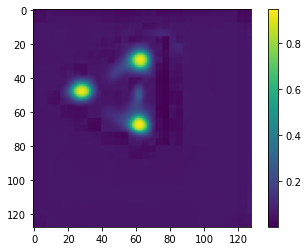

loss: 47.583850  [72832/90000]
loss: 43.610373  [72960/90000]
loss: 41.714370  [73088/90000]
loss: 42.936310  [73216/90000]
loss: 46.987387  [73344/90000]
loss: 46.227311  [73472/90000]
loss: 45.344341  [73600/90000]
loss: 45.331650  [73728/90000]


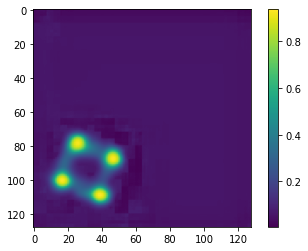

loss: 46.723907  [73856/90000]
loss: 44.889942  [73984/90000]
loss: 50.036400  [74112/90000]
loss: 44.140242  [74240/90000]
loss: 49.787755  [74368/90000]
loss: 48.646211  [74496/90000]
loss: 44.037031  [74624/90000]
loss: 46.956996  [74752/90000]


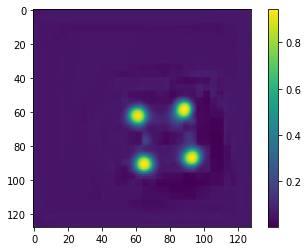

loss: 49.461653  [74880/90000]
loss: 47.653005  [75008/90000]
loss: 47.230719  [75136/90000]
loss: 49.673992  [75264/90000]
loss: 48.120687  [75392/90000]
loss: 47.527499  [75520/90000]
loss: 44.377528  [75648/90000]
loss: 46.532483  [75776/90000]


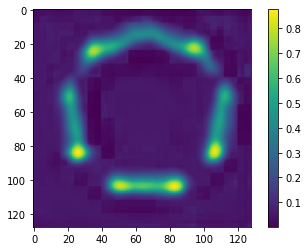

loss: 46.649321  [75904/90000]
loss: 45.206562  [76032/90000]
loss: 46.087318  [76160/90000]
loss: 41.174236  [76288/90000]
loss: 45.046952  [76416/90000]
loss: 46.986172  [76544/90000]
loss: 46.354478  [76672/90000]
loss: 45.507465  [76800/90000]


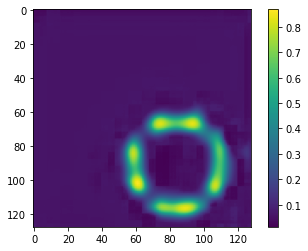

loss: 44.073056  [76928/90000]
loss: 42.732754  [77056/90000]
loss: 48.007162  [77184/90000]
loss: 50.680720  [77312/90000]
loss: 46.448796  [77440/90000]
loss: 48.865490  [77568/90000]
loss: 52.078095  [77696/90000]
loss: 50.340019  [77824/90000]


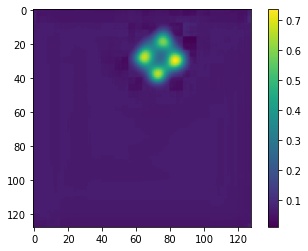

loss: 51.530690  [77952/90000]
loss: 44.301181  [78080/90000]
loss: 44.066469  [78208/90000]
loss: 44.165480  [78336/90000]
loss: 46.944707  [78464/90000]
loss: 44.968757  [78592/90000]
loss: 41.645719  [78720/90000]
loss: 44.781303  [78848/90000]


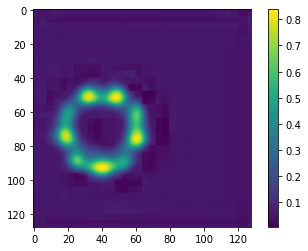

loss: 45.493374  [78976/90000]
loss: 46.377836  [79104/90000]
loss: 47.977902  [79232/90000]
loss: 46.616346  [79360/90000]
loss: 45.259737  [79488/90000]
loss: 48.003726  [79616/90000]
loss: 46.519394  [79744/90000]
loss: 44.522060  [79872/90000]


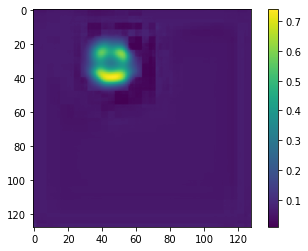

loss: 43.911281  [80000/90000]
loss: 44.830316  [80128/90000]
loss: 41.327794  [80256/90000]
loss: 46.550202  [80384/90000]
loss: 43.834347  [80512/90000]
loss: 44.890935  [80640/90000]
loss: 41.895390  [80768/90000]
loss: 49.652801  [80896/90000]


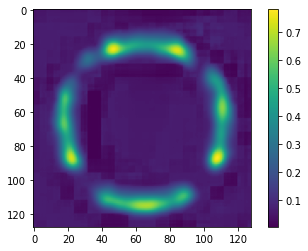

loss: 42.596530  [81024/90000]
loss: 47.436823  [81152/90000]
loss: 46.869357  [81280/90000]
loss: 44.204223  [81408/90000]
loss: 41.554004  [81536/90000]
loss: 47.608600  [81664/90000]
loss: 40.740172  [81792/90000]
loss: 45.620379  [81920/90000]


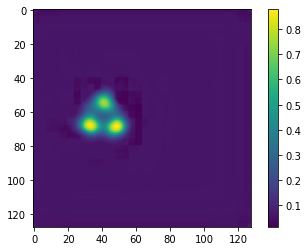

loss: 45.887768  [82048/90000]
loss: 46.017148  [82176/90000]
loss: 38.968792  [82304/90000]
loss: 42.922665  [82432/90000]
loss: 43.886428  [82560/90000]
loss: 41.939121  [82688/90000]
loss: 46.933523  [82816/90000]
loss: 41.726185  [82944/90000]


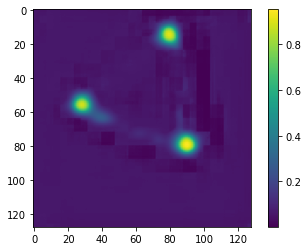

loss: 43.073364  [83072/90000]
loss: 42.664292  [83200/90000]
loss: 40.530889  [83328/90000]
loss: 43.220094  [83456/90000]
loss: 46.742256  [83584/90000]
loss: 43.504699  [83712/90000]
loss: 47.335821  [83840/90000]
loss: 47.759230  [83968/90000]


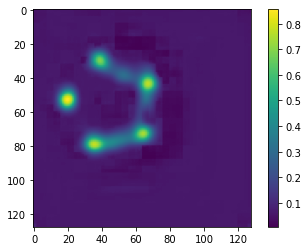

loss: 41.476166  [84096/90000]
loss: 48.659928  [84224/90000]
loss: 42.889847  [84352/90000]
loss: 40.693764  [84480/90000]
loss: 40.805918  [84608/90000]
loss: 43.606144  [84736/90000]
loss: 42.646147  [84864/90000]
loss: 42.493489  [84992/90000]


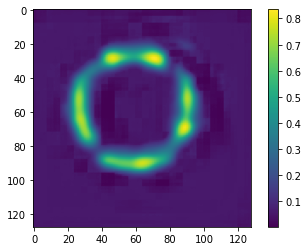

loss: 44.336528  [85120/90000]
loss: 43.584279  [85248/90000]
loss: 44.771141  [85376/90000]
loss: 46.437507  [85504/90000]
loss: 45.341976  [85632/90000]
loss: 41.564543  [85760/90000]
loss: 41.883980  [85888/90000]
loss: 38.950086  [86016/90000]


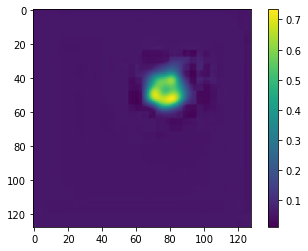

loss: 44.112981  [86144/90000]
loss: 45.649123  [86272/90000]
loss: 45.072588  [86400/90000]
loss: 44.437765  [86528/90000]
loss: 46.525777  [86656/90000]
loss: 49.134582  [86784/90000]
loss: 45.894101  [86912/90000]
loss: 39.631870  [87040/90000]


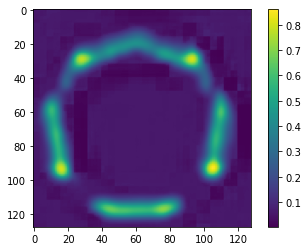

loss: 41.942264  [87168/90000]
loss: 50.872929  [87296/90000]
loss: 42.206582  [87424/90000]
loss: 41.342730  [87552/90000]
loss: 42.141659  [87680/90000]
loss: 45.778774  [87808/90000]
loss: 43.405372  [87936/90000]
loss: 43.095882  [88064/90000]


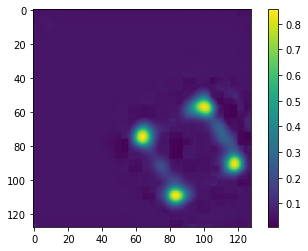

loss: 41.215577  [88192/90000]
loss: 44.392843  [88320/90000]
loss: 40.499451  [88448/90000]
loss: 40.928943  [88576/90000]
loss: 48.701698  [88704/90000]
loss: 44.578969  [88832/90000]
loss: 40.933358  [88960/90000]
loss: 43.632841  [89088/90000]


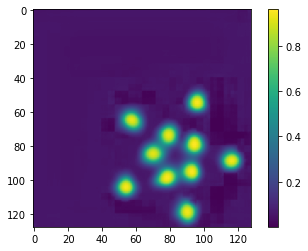

loss: 45.076035  [89216/90000]
loss: 42.601898  [89344/90000]
loss: 44.696947  [89472/90000]
loss: 49.915191  [89600/90000]
loss: 32.714276  [47668/90000]
loss: 40.324623  [    0/90000]


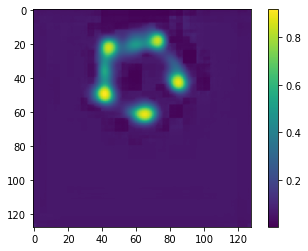

loss: 41.948001  [  128/90000]
loss: 45.188327  [  256/90000]
loss: 44.286284  [  384/90000]
loss: 42.405871  [  512/90000]
loss: 44.294099  [  640/90000]
loss: 42.607248  [  768/90000]
loss: 43.322848  [  896/90000]
loss: 45.739380  [ 1024/90000]


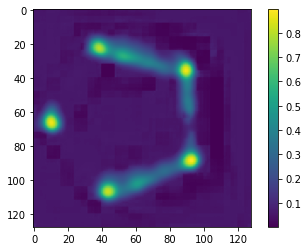

loss: 45.843709  [ 1152/90000]
loss: 48.111400  [ 1280/90000]
loss: 42.748637  [ 1408/90000]
loss: 42.275927  [ 1536/90000]
loss: 46.894756  [ 1664/90000]
loss: 42.232324  [ 1792/90000]
loss: 44.185288  [ 1920/90000]
loss: 45.755296  [ 2048/90000]


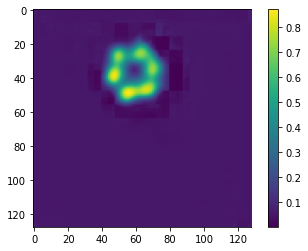

loss: 40.800093  [ 2176/90000]
loss: 43.555432  [ 2304/90000]
loss: 44.398947  [ 2432/90000]
loss: 48.018412  [ 2560/90000]
loss: 41.694000  [ 2688/90000]
loss: 48.120127  [ 2816/90000]
loss: 44.406919  [ 2944/90000]
loss: 41.891612  [ 3072/90000]


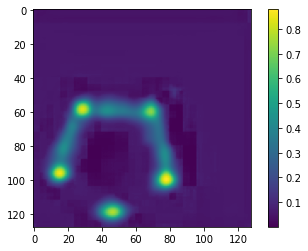

loss: 43.676089  [ 3200/90000]
loss: 41.522925  [ 3328/90000]
loss: 41.542543  [ 3456/90000]
loss: 41.011322  [ 3584/90000]
loss: 44.764195  [ 3712/90000]
loss: 46.453771  [ 3840/90000]
loss: 46.742952  [ 3968/90000]
loss: 42.798859  [ 4096/90000]


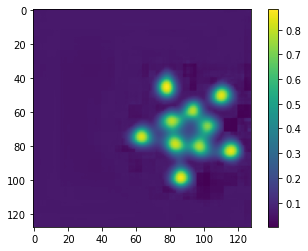

loss: 47.412625  [ 4224/90000]
loss: 41.224310  [ 4352/90000]
loss: 48.503594  [ 4480/90000]
loss: 46.427953  [ 4608/90000]
loss: 40.343502  [ 4736/90000]
loss: 45.063079  [ 4864/90000]
loss: 43.707572  [ 4992/90000]
loss: 41.867322  [ 5120/90000]


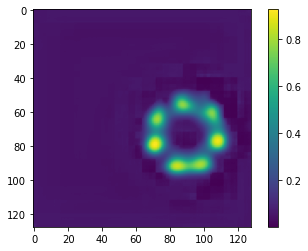

loss: 41.206811  [ 5248/90000]
loss: 50.006968  [ 5376/90000]
loss: 48.881895  [ 5504/90000]
loss: 50.423383  [ 5632/90000]
loss: 41.707209  [ 5760/90000]
loss: 45.700528  [ 5888/90000]
loss: 50.567351  [ 6016/90000]
loss: 39.960352  [ 6144/90000]


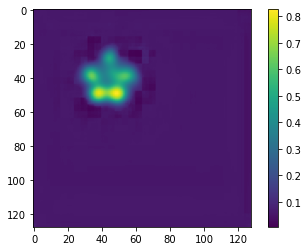

loss: 45.449978  [ 6272/90000]
loss: 43.881927  [ 6400/90000]
loss: 43.153788  [ 6528/90000]
loss: 40.670475  [ 6656/90000]
loss: 44.067725  [ 6784/90000]
loss: 48.900180  [ 6912/90000]
loss: 42.546515  [ 7040/90000]
loss: 40.880080  [ 7168/90000]


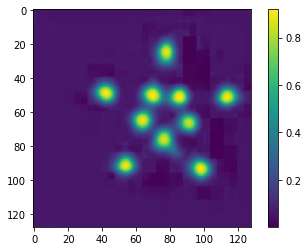

loss: 46.832387  [ 7296/90000]
loss: 43.405835  [ 7424/90000]
loss: 45.111127  [ 7552/90000]
loss: 47.419454  [ 7680/90000]
loss: 42.831333  [ 7808/90000]
loss: 44.683736  [ 7936/90000]
loss: 43.227200  [ 8064/90000]
loss: 42.587030  [ 8192/90000]


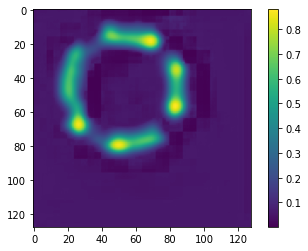

loss: 41.484775  [ 8320/90000]
loss: 42.423641  [ 8448/90000]
loss: 42.038371  [ 8576/90000]
loss: 50.168551  [ 8704/90000]
loss: 43.747765  [ 8832/90000]
loss: 40.084079  [ 8960/90000]
loss: 45.486748  [ 9088/90000]
loss: 40.324361  [ 9216/90000]


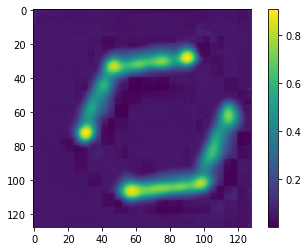

loss: 38.891487  [ 9344/90000]
loss: 43.405238  [ 9472/90000]
loss: 43.284857  [ 9600/90000]
loss: 49.398017  [ 9728/90000]
loss: 42.589530  [ 9856/90000]
loss: 41.410412  [ 9984/90000]
loss: 46.642366  [10112/90000]
loss: 47.968651  [10240/90000]


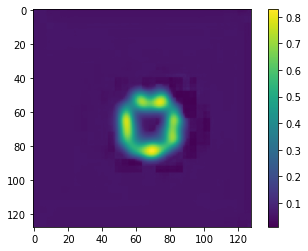

loss: 44.308282  [10368/90000]
loss: 44.211095  [10496/90000]
loss: 44.410223  [10624/90000]
loss: 42.076221  [10752/90000]
loss: 45.386527  [10880/90000]
loss: 38.831967  [11008/90000]
loss: 41.776305  [11136/90000]
loss: 42.273052  [11264/90000]


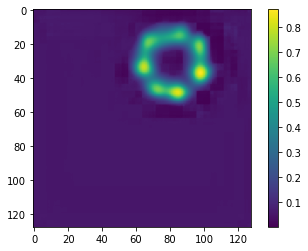

loss: 44.861607  [11392/90000]
loss: 42.654054  [11520/90000]
loss: 39.592199  [11648/90000]
loss: 43.095168  [11776/90000]
loss: 44.362844  [11904/90000]
loss: 40.238044  [12032/90000]
loss: 40.816335  [12160/90000]
loss: 42.038606  [12288/90000]


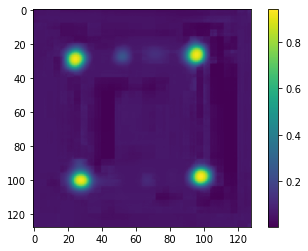

loss: 45.106737  [12416/90000]
loss: 40.845565  [12544/90000]
loss: 40.726540  [12672/90000]
loss: 42.448520  [12800/90000]
loss: 43.769395  [12928/90000]
loss: 46.286232  [13056/90000]
loss: 41.940368  [13184/90000]
loss: 34.052400  [13312/90000]


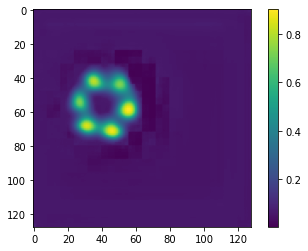

loss: 48.279753  [13440/90000]
loss: 41.574854  [13568/90000]
loss: 43.596601  [13696/90000]
loss: 46.171806  [13824/90000]
loss: 43.791255  [13952/90000]
loss: 38.761462  [14080/90000]
loss: 42.700144  [14208/90000]
loss: 46.701913  [14336/90000]


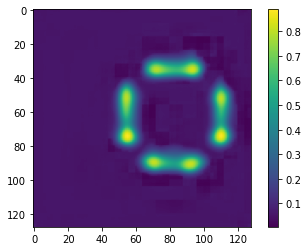

loss: 49.231661  [14464/90000]
loss: 43.436569  [14592/90000]
loss: 46.855225  [14720/90000]
loss: 40.470506  [14848/90000]
loss: 50.231817  [14976/90000]
loss: 44.292729  [15104/90000]
loss: 40.326862  [15232/90000]
loss: 42.262573  [15360/90000]


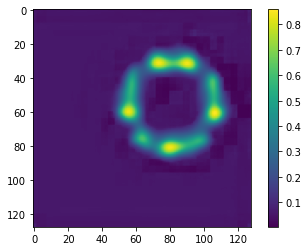

loss: 46.360054  [15488/90000]
loss: 46.828922  [15616/90000]
loss: 45.013769  [15744/90000]
loss: 46.208058  [15872/90000]
loss: 48.210301  [16000/90000]
loss: 40.736409  [16128/90000]
loss: 37.173449  [16256/90000]
loss: 45.604425  [16384/90000]


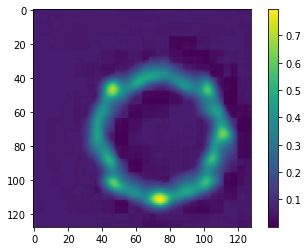

loss: 41.911352  [16512/90000]
loss: 40.204522  [16640/90000]
loss: 39.743017  [16768/90000]
loss: 42.490365  [16896/90000]
loss: 41.205779  [17024/90000]
loss: 42.884059  [17152/90000]
loss: 46.574751  [17280/90000]
loss: 44.485063  [17408/90000]


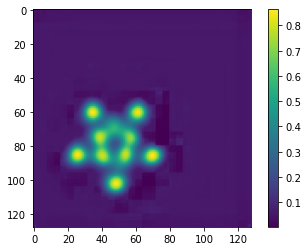

loss: 41.315173  [17536/90000]
loss: 39.735863  [17664/90000]
loss: 43.676623  [17792/90000]
loss: 42.564782  [17920/90000]
loss: 41.701248  [18048/90000]
loss: 39.060520  [18176/90000]
loss: 39.432054  [18304/90000]
loss: 40.291336  [18432/90000]


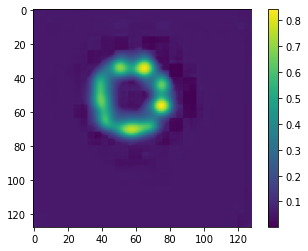

loss: 43.944325  [18560/90000]
loss: 40.320486  [18688/90000]
loss: 43.913172  [18816/90000]
loss: 44.009729  [18944/90000]
loss: 44.955689  [19072/90000]
loss: 38.454073  [19200/90000]
loss: 37.944672  [19328/90000]
loss: 45.424634  [19456/90000]


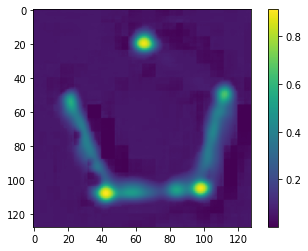

loss: 44.404329  [19584/90000]
loss: 43.557891  [19712/90000]
loss: 37.364934  [19840/90000]
loss: 39.423860  [19968/90000]
loss: 40.673109  [20096/90000]
loss: 43.336189  [20224/90000]
loss: 39.136214  [20352/90000]
loss: 41.654033  [20480/90000]


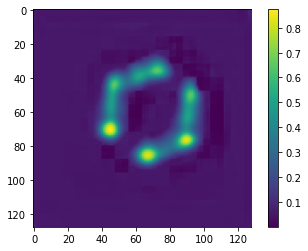

loss: 42.058690  [20608/90000]
loss: 48.495465  [20736/90000]
loss: 39.637063  [20864/90000]
loss: 42.769613  [20992/90000]
loss: 43.264307  [21120/90000]
loss: 40.750835  [21248/90000]
loss: 44.205385  [21376/90000]
loss: 44.331017  [21504/90000]


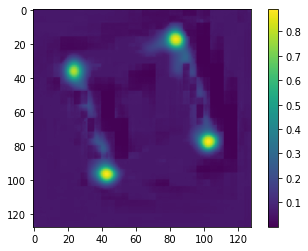

loss: 35.928360  [21632/90000]
loss: 39.359924  [21760/90000]
loss: 41.214891  [21888/90000]
loss: 42.173651  [22016/90000]
loss: 41.163867  [22144/90000]
loss: 43.511151  [22272/90000]
loss: 41.712283  [22400/90000]
loss: 44.120577  [22528/90000]


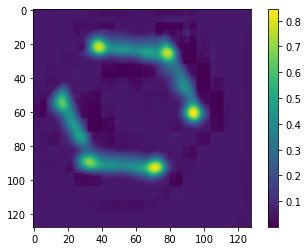

loss: 40.095318  [22656/90000]
loss: 41.068672  [22784/90000]
loss: 42.855088  [22912/90000]
loss: 43.459603  [23040/90000]
loss: 49.161373  [23168/90000]
loss: 43.341855  [23296/90000]
loss: 42.223251  [23424/90000]
loss: 39.744163  [23552/90000]


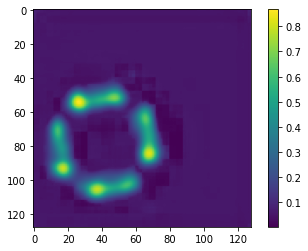

loss: 38.724079  [23680/90000]
loss: 46.531312  [23808/90000]
loss: 43.374626  [23936/90000]
loss: 45.252365  [24064/90000]
loss: 44.950804  [24192/90000]
loss: 41.299797  [24320/90000]
loss: 40.680692  [24448/90000]
loss: 42.757187  [24576/90000]


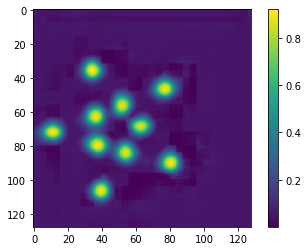

loss: 43.443485  [24704/90000]
loss: 43.129362  [24832/90000]
loss: 41.744226  [24960/90000]
loss: 39.819134  [25088/90000]
loss: 44.454199  [25216/90000]
loss: 38.565943  [25344/90000]
loss: 43.330782  [25472/90000]
loss: 42.462629  [25600/90000]


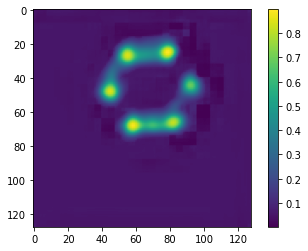

loss: 48.781422  [25728/90000]
loss: 42.740026  [25856/90000]
loss: 45.783864  [25984/90000]
loss: 38.073836  [26112/90000]
loss: 43.524479  [26240/90000]
loss: 41.242721  [26368/90000]
loss: 37.143483  [26496/90000]
loss: 43.162579  [26624/90000]


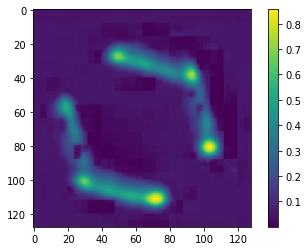

loss: 40.318706  [26752/90000]
loss: 38.253733  [26880/90000]
loss: 39.346591  [27008/90000]
loss: 39.708476  [27136/90000]
loss: 43.467947  [27264/90000]
loss: 36.474542  [27392/90000]
loss: 42.137140  [27520/90000]
loss: 42.292509  [27648/90000]


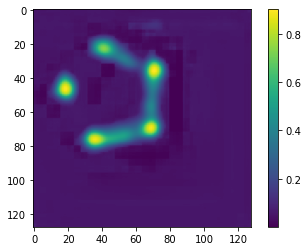

loss: 40.530222  [27776/90000]
loss: 39.569582  [27904/90000]
loss: 43.388092  [28032/90000]
loss: 38.027982  [28160/90000]
loss: 41.737304  [28288/90000]
loss: 40.355392  [28416/90000]
loss: 41.324379  [28544/90000]
loss: 43.055260  [28672/90000]


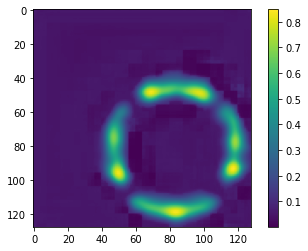

loss: 44.857928  [28800/90000]
loss: 42.486435  [28928/90000]
loss: 40.396565  [29056/90000]
loss: 40.215772  [29184/90000]
loss: 40.777031  [29312/90000]
loss: 41.166298  [29440/90000]
loss: 42.859506  [29568/90000]
loss: 43.943902  [29696/90000]


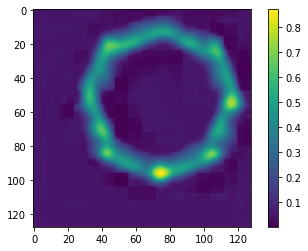

loss: 40.868462  [29824/90000]
loss: 43.207115  [29952/90000]
loss: 43.971787  [30080/90000]
loss: 37.086877  [30208/90000]
loss: 42.982769  [30336/90000]
loss: 37.991283  [30464/90000]
loss: 41.444158  [30592/90000]
loss: 40.143199  [30720/90000]


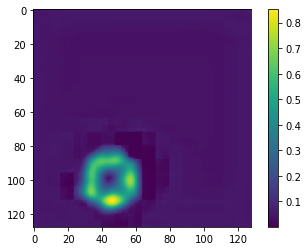

loss: 42.443722  [30848/90000]
loss: 41.618211  [30976/90000]
loss: 42.032485  [31104/90000]
loss: 38.490379  [31232/90000]
loss: 38.819217  [31360/90000]
loss: 40.883033  [31488/90000]
loss: 46.039983  [31616/90000]
loss: 42.309028  [31744/90000]


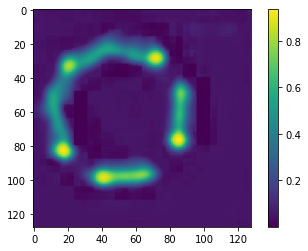

loss: 45.288609  [31872/90000]
loss: 41.815331  [32000/90000]
loss: 41.865353  [32128/90000]
loss: 40.595830  [32256/90000]
loss: 44.406300  [32384/90000]
loss: 39.826437  [32512/90000]
loss: 35.260863  [32640/90000]
loss: 42.196114  [32768/90000]


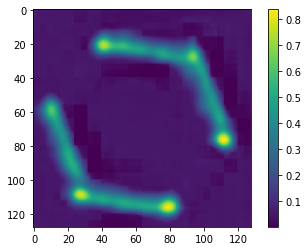

loss: 43.322610  [32896/90000]
loss: 42.103791  [33024/90000]
loss: 43.386273  [33152/90000]
loss: 43.629323  [33280/90000]
loss: 39.378819  [33408/90000]
loss: 41.979419  [33536/90000]
loss: 46.422824  [33664/90000]
loss: 39.876099  [33792/90000]


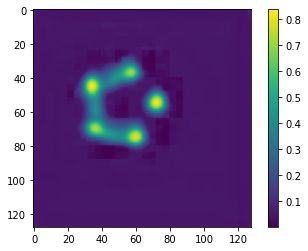

loss: 41.063391  [33920/90000]
loss: 40.069566  [34048/90000]
loss: 38.166480  [34176/90000]
loss: 39.009661  [34304/90000]
loss: 39.687865  [34432/90000]
loss: 40.710143  [34560/90000]
loss: 38.493791  [34688/90000]
loss: 41.002578  [34816/90000]


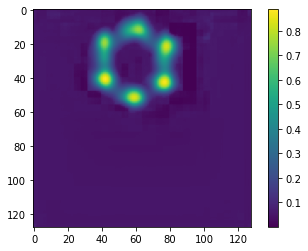

loss: 40.568560  [34944/90000]
loss: 46.538970  [35072/90000]
loss: 41.690978  [35200/90000]
loss: 42.603300  [35328/90000]
loss: 43.785542  [35456/90000]
loss: 42.762853  [35584/90000]
loss: 42.016199  [35712/90000]
loss: 39.690013  [35840/90000]


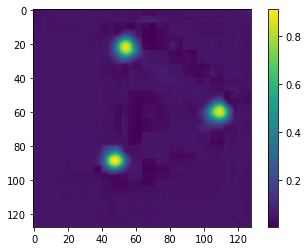

loss: 42.510504  [35968/90000]
loss: 40.473238  [36096/90000]
loss: 43.182391  [36224/90000]
loss: 46.498714  [36352/90000]
loss: 43.062721  [36480/90000]
loss: 44.888339  [36608/90000]
loss: 38.792577  [36736/90000]
loss: 43.588889  [36864/90000]


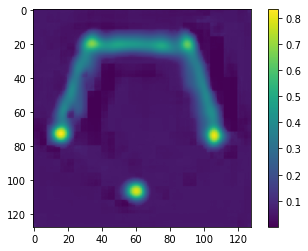

loss: 37.643023  [36992/90000]
loss: 38.240319  [37120/90000]
loss: 39.816048  [37248/90000]
loss: 43.098761  [37376/90000]
loss: 41.285609  [37504/90000]
loss: 38.593529  [37632/90000]
loss: 37.609938  [37760/90000]
loss: 51.538159  [37888/90000]


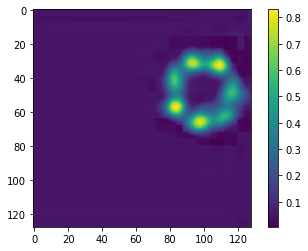

loss: 39.168587  [38016/90000]
loss: 41.055342  [38144/90000]
loss: 38.165380  [38272/90000]
loss: 43.407885  [38400/90000]
loss: 42.838883  [38528/90000]
loss: 37.366542  [38656/90000]
loss: 40.355522  [38784/90000]
loss: 40.048928  [38912/90000]


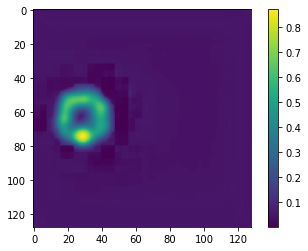

loss: 43.276589  [39040/90000]
loss: 40.908516  [39168/90000]
loss: 40.419636  [39296/90000]
loss: 43.643232  [39424/90000]
loss: 39.966756  [39552/90000]
loss: 41.591230  [39680/90000]
loss: 40.969428  [39808/90000]
loss: 45.744883  [39936/90000]


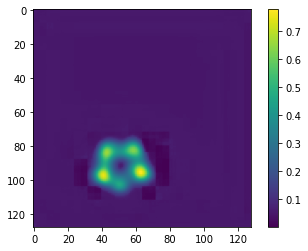

loss: 39.480128  [40064/90000]
loss: 40.312055  [40192/90000]
loss: 39.360473  [40320/90000]
loss: 43.322512  [40448/90000]
loss: 40.676304  [40576/90000]
loss: 40.062350  [40704/90000]
loss: 45.025614  [40832/90000]
loss: 39.755820  [40960/90000]


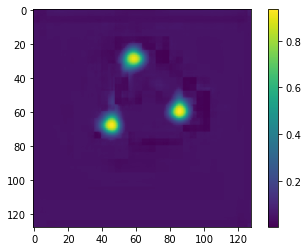

loss: 39.763394  [41088/90000]
loss: 45.276749  [41216/90000]
loss: 41.532416  [41344/90000]
loss: 42.987037  [41472/90000]
loss: 42.880004  [41600/90000]
loss: 40.490719  [41728/90000]
loss: 42.676023  [41856/90000]
loss: 43.917830  [41984/90000]


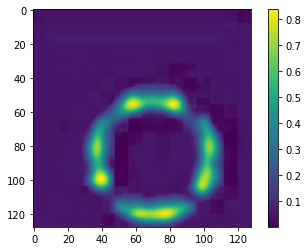

loss: 36.186336  [42112/90000]
loss: 40.299530  [42240/90000]
loss: 45.481196  [42368/90000]
loss: 37.420237  [42496/90000]
loss: 39.066802  [42624/90000]
loss: 42.707021  [42752/90000]
loss: 38.038858  [42880/90000]
loss: 41.022616  [43008/90000]


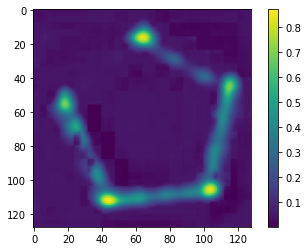

KeyboardInterrupt: 

In [17]:
import wandb

config = dict (
    learning_rate =lr,
    momentum = m,
    batchsize = 128,
    architecture = "similar to resnet",
    dataset_id = "shape dataset",
)

wandb.init(
    project="feature detection on different shapes",
    config=config,
)

for epoch in range(4):
    for batch, (xb, yb) in enumerate(train_dataloader):
        #print(len(xb))
        X, y = xb.to(device), yb.to(device)
        #print(X.shape)
        # Compute prediction error
        pred = model(X)
        #print(pred.shape,y.shape)
        loss = loss_function(pred,y)
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
            model.zero_grad()
        wandb.log({"train_loss": loss.item(), "epoch": 4,"lr" : lr,})
        if batch % 2 == 0:
            loss, current = loss.item(), (batch)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{90000:>5d}]")
        if batch % 16 == 0:
            plt.figure()
            plt.imshow(pred[0].cpu().detach().numpy().reshape(128,128,1))
            plt.colorbar()
            plt.show()

<ipython-input-18-f52fbc278ff4>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


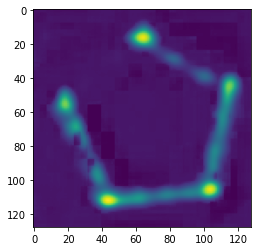

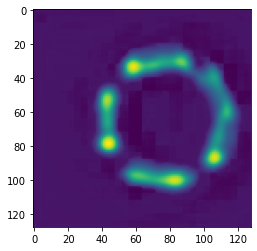

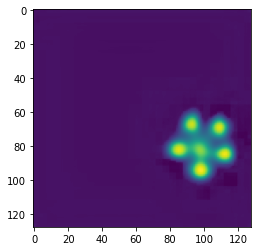

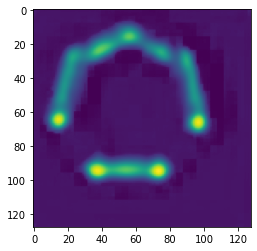

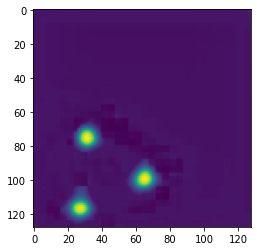

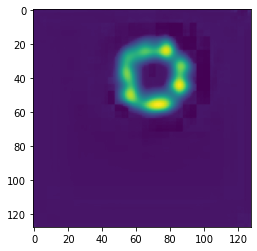

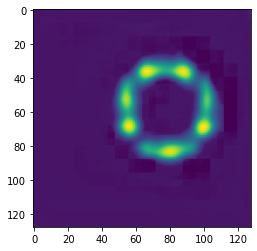

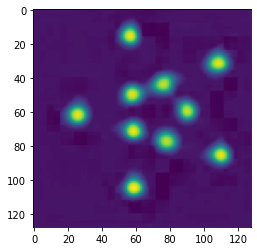

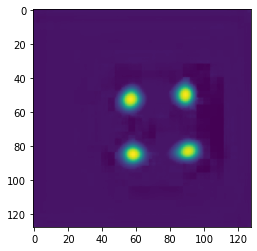

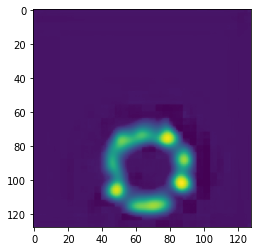

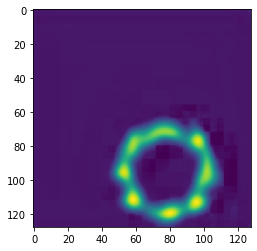

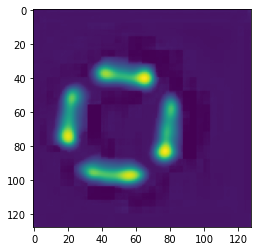

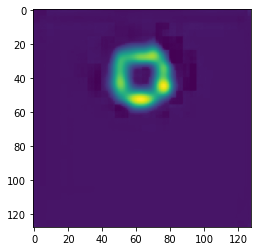

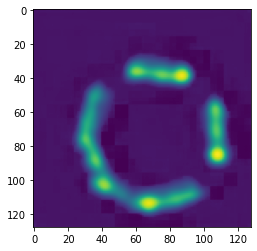

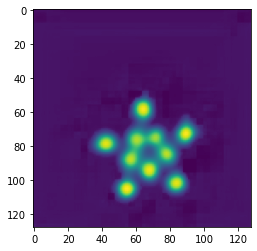

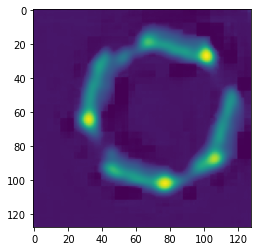

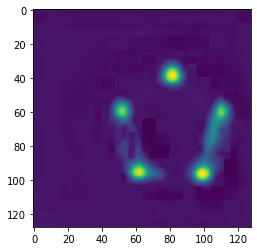

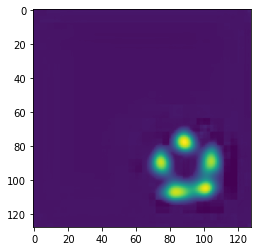

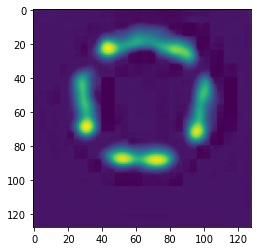

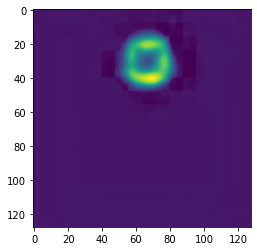

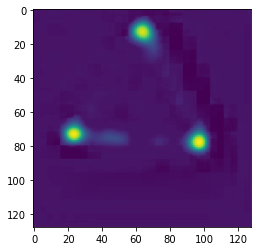

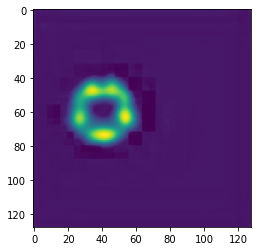

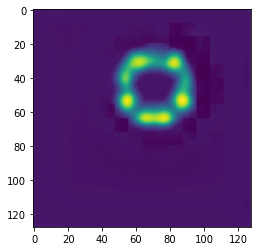

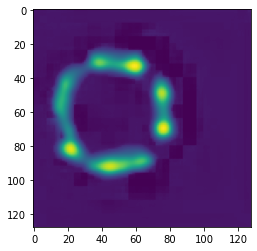

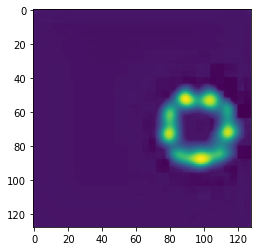

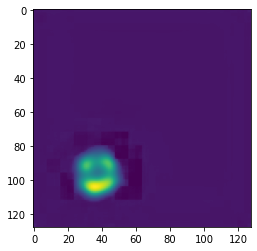

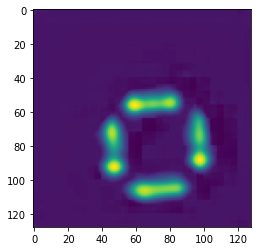

In [18]:
for i in range(27):
    plt.figure()
    plt.imshow(pred[i].cpu().detach().numpy().reshape(128,128,1))

torch.save(model, 'features.pth')

In [21]:
torch.save(model, 'features.pth')